In [2]:
import os
import time
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
features = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [4]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [5]:
DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,0.003307,0.002409,...,1.280704,1.386294,1.396967,0.000703,0.065298,0.006188,0.009186,3.487845,14.708341,0.012476
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.005253,0.008123,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.005203,0.009098,...,1.217019,0.722551,0.846374,0.006222,0.897081,0.042083,0.088483,6.029726,46.903740,0.011594
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,0.004530,0.006995,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.006927,0.013675,...,1.319454,0.953987,1.503321,0.007170,0.752276,0.065797,0.091757,3.083533,14.513282,0.016023


In [45]:
features_list = list(DataFeatures.columns[8:])
MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

pca = PCA(n_components = 3)
princComp = pca.fit_transform(Features)
princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
DataPCA = pd.concat([MetaData, princComp], axis = 1)

print(pca.explained_variance_ratio_)
DataPCA.head()

[0.29014175 0.13272264 0.06526321]


,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,PC1,PC2,PC3
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,-1.876328,0.759230,-0.688153
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.213879,3.029146,-2.034597
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.205672,2.509806,-1.690087
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,-0.607318,0.473543,-1.565732
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.243753,-0.335152,-0.411174


In [7]:
def plotPCA(sympt, tasks, scored, comp):
    
    features_list = list(DataFeatures.columns[8:])
    MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
    Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

    pca = PCA(n_components = comp)
    princComp = pca.fit_transform(Features)
    if comp == 3:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
    if comp == 2:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'])
    
    DataPCA = pd.concat([MetaData, princComp], axis = 1)
    indices = (x for x in range(len(DataPCA)) if DataPCA.TaskAbb.values[x] in tasks)
    DataPCA = DataPCA.loc[indices]
    
    if comp == 3:
        fig = plt.figure(figsize = (16, 12))
        ax = Axes3D(fig)
    if comp == 2:
        plt.figure(figsize = (16, 12))
    if scored:
        Scores = list(DataPCA[sympt].unique())
    else:
        Scores = ['Symptomatic', 'Non-Symptomatic']
    for score in Scores:
        if not type(score) == str:
            if np.isnan(score):
                continue
        if scored or sympt == 'TaskAbb':
            ScoreData = DataPCA[DataPCA[sympt] == score]
        elif score == 'Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] > 0]
        elif score == 'Non-Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] == 0]
        if comp == 3:
            ax.scatter(ScoreData.PC1.values, ScoreData.PC2.values, ScoreData.PC3.values)
        if comp == 2:
            plt.scatter(ScoreData.PC1.values, ScoreData.PC2.values)
    plt.legend(Scores)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    if comp == 3:
        ax.set_zlabel('Principle Component 3')
        
#     ax.set_zlim3d(-5, 10)
#     ax.set_ylim3d(-10, 5)
#     ax.set_xlim3d(-5, 10)
    
    return DataPCA

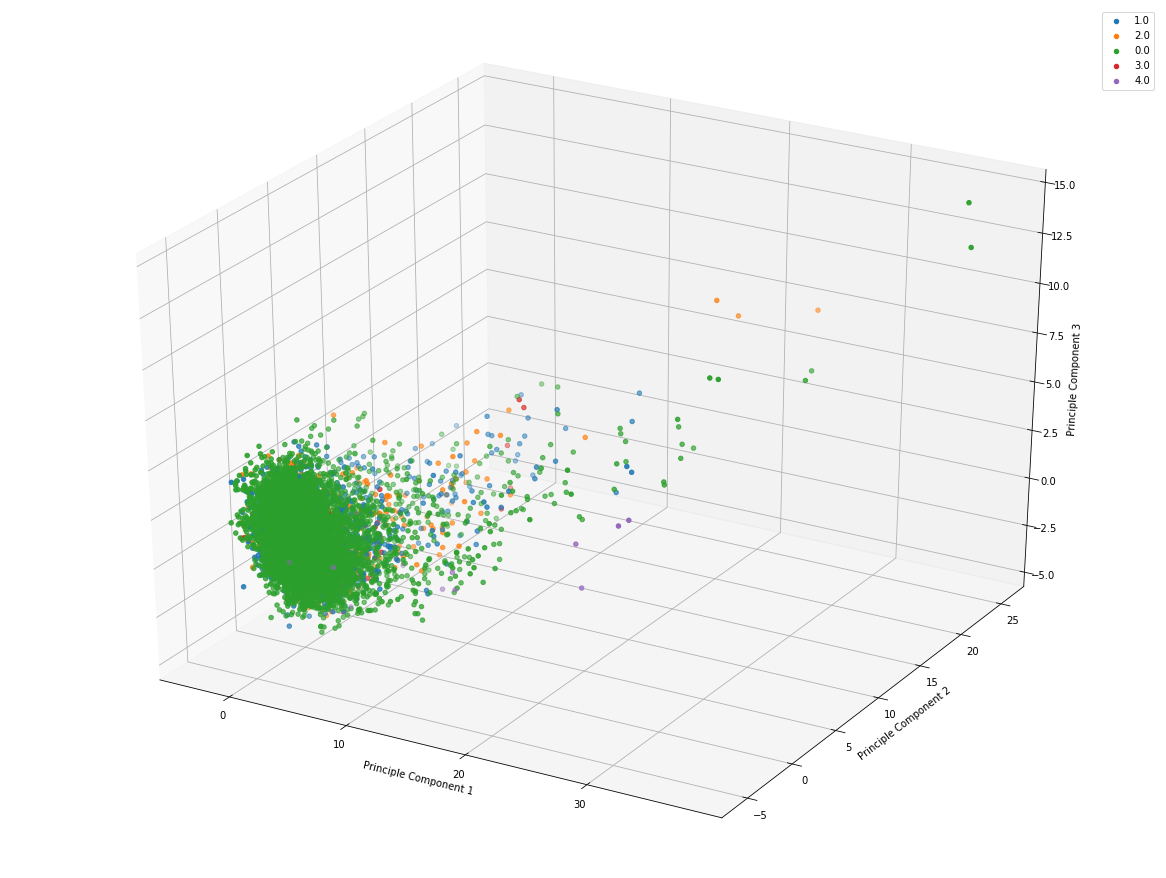

In [32]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

DataPCA = plotPCA(label_type, tasks, True, 3)

In [9]:
def TrainTestCluster(tasks, clusters):
    
    pd.options.mode.chained_assignment = None
    
    km = KMeans(n_clusters = clusters)
    
    DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
        
    features_list = list(DataFeatures.columns[8:])

    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    
    DataClusters = pd.DataFrame()
    
    for subj in DataFeatures.SubjID.unique():
        
        SubjFeatures = DataFeatures[DataFeatures.SubjID == subj]
        X = SubjFeatures[features_list].values
        
        km.fit(X)
        
        ClusterLab = km.labels_
        SubjFeatures['Cluster'] = ClusterLab
        cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster'] + features_list
        SubjFeatures = SubjFeatures[cols]
        if DataClusters.empty:
            DataClusters = SubjFeatures
            continue
        DataClusters = pd.concat([DataClusters, SubjFeatures], ignore_index = True)
        
        MetaData = SubjFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster']]
        Features = StandardScaler().fit_transform(SubjFeatures[features_list].values)

        pca = PCA(n_components = 2)
        princComp = pca.fit_transform(Features)
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'], index = MetaData.index)

        DataPCA = pd.concat([MetaData, princComp], axis = 1)

        plt.figure(figsize = (8, 6))
        
        Clusters = list(DataPCA.Cluster.unique())
        
        for cluster in Clusters:
            ClusterData = DataPCA[DataPCA.Cluster == cluster]
            plt.scatter(ClusterData.PC1.values, ClusterData.PC2.values)
        plt.legend(Clusters)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.show()
        
    return DataClusters, km, pca

Tasks Considered:
    Drawing on a paper
    Sitting
    Standing


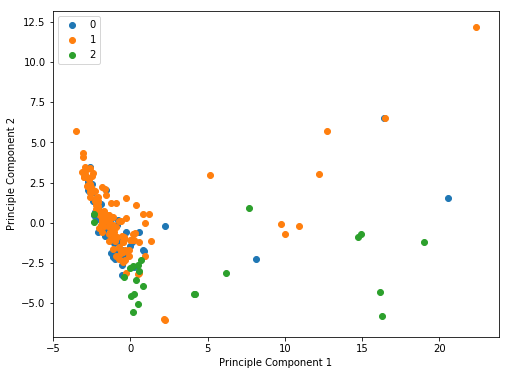

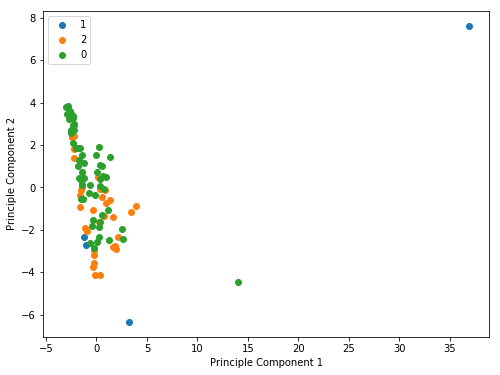

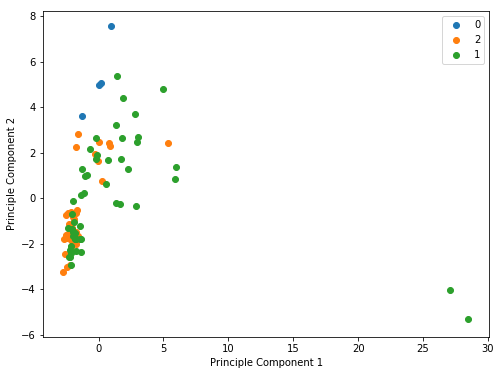

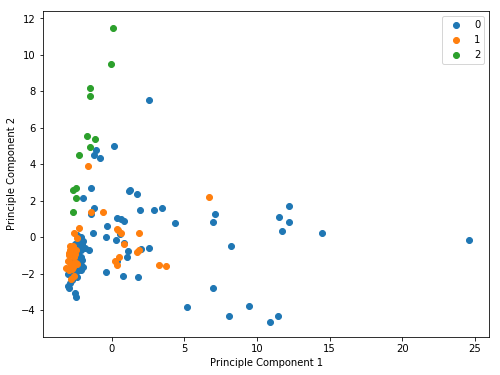

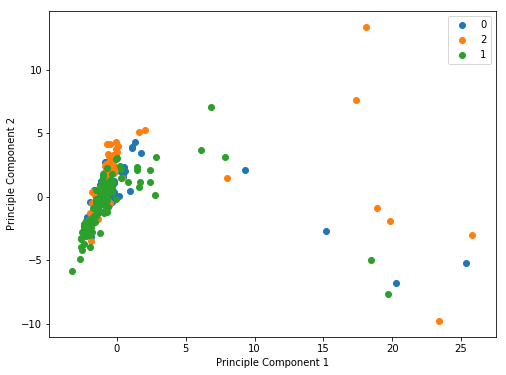

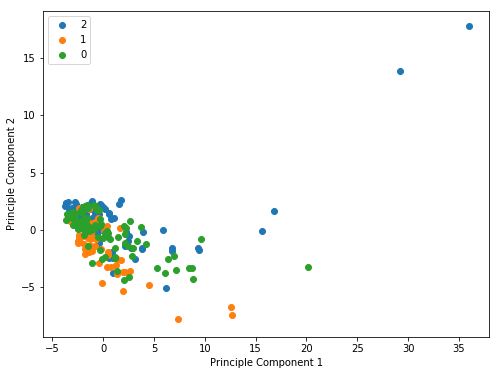

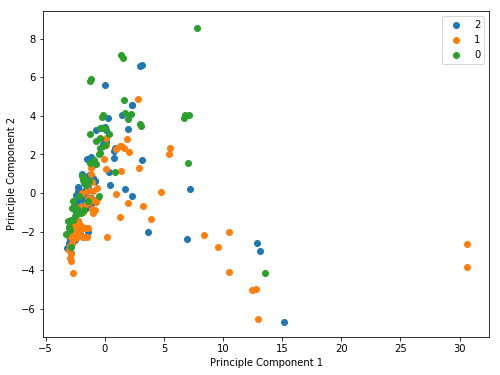

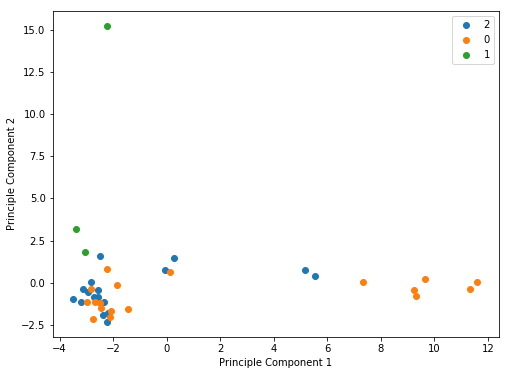

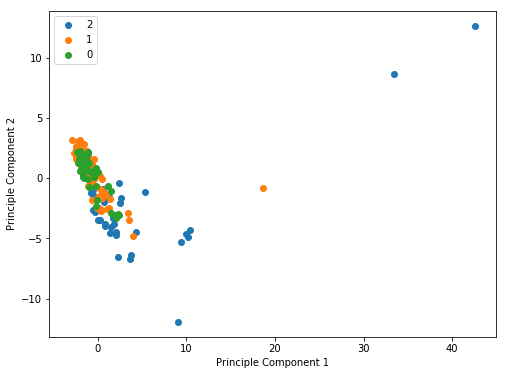

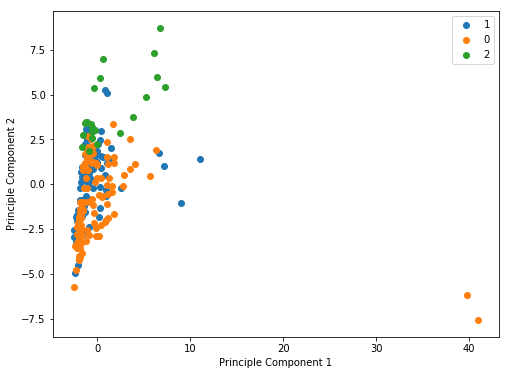

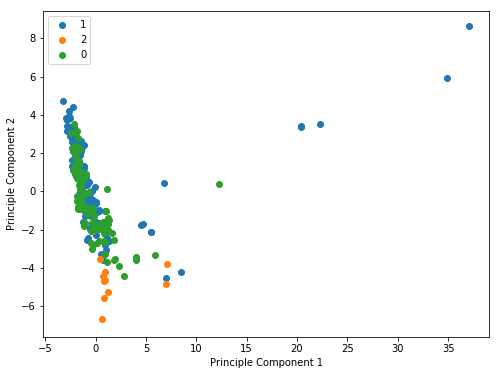

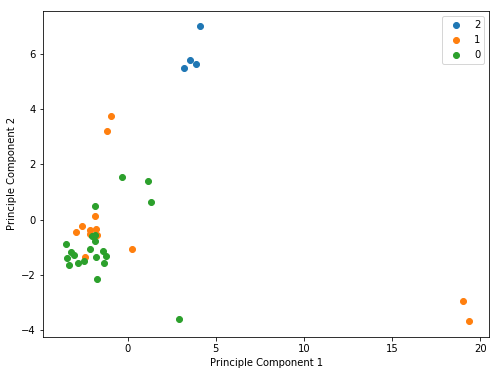

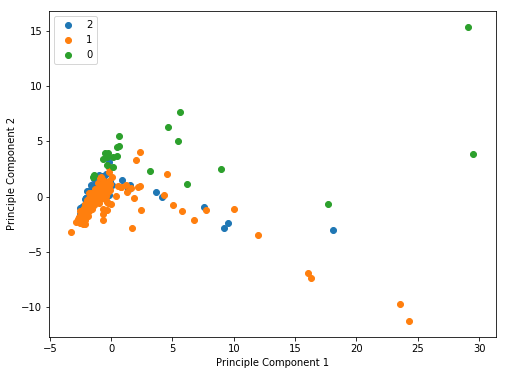

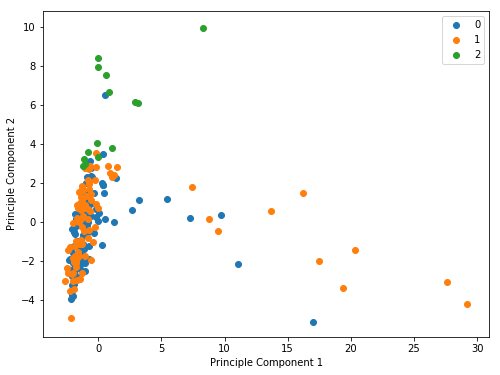

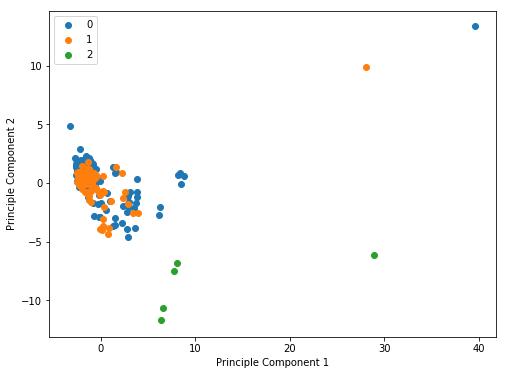

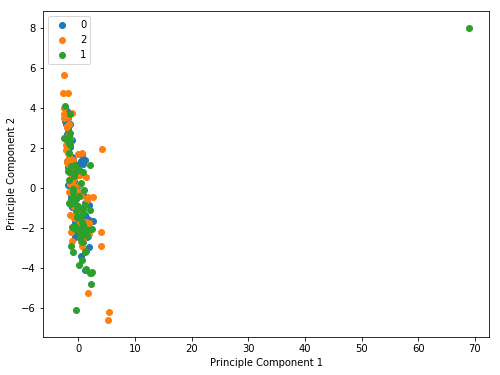

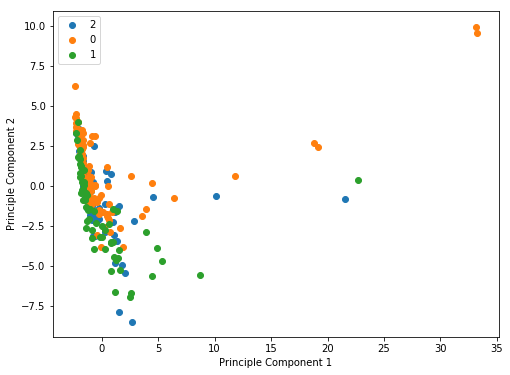

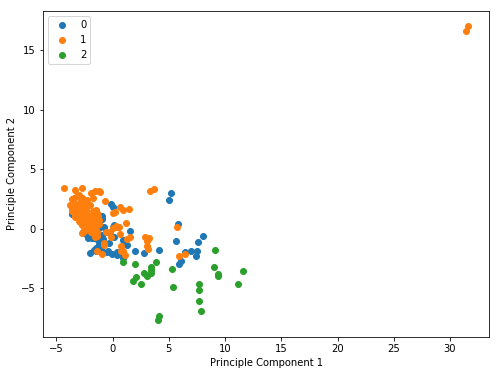

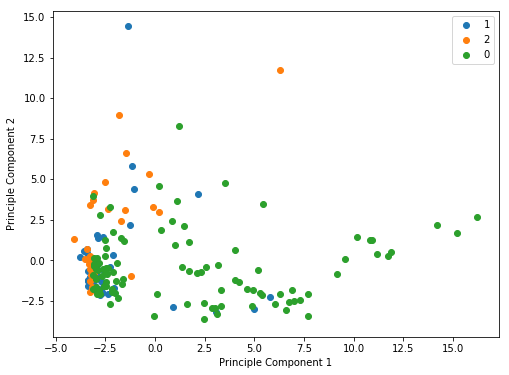

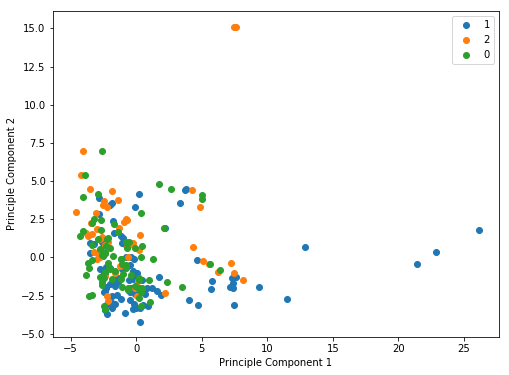

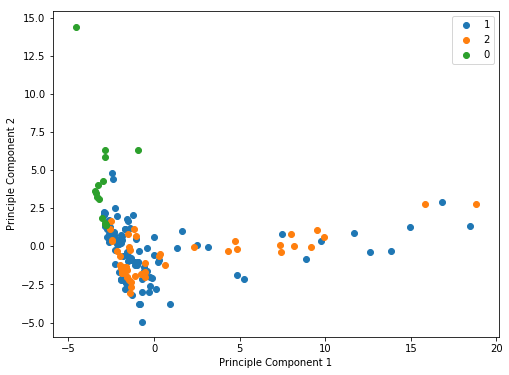

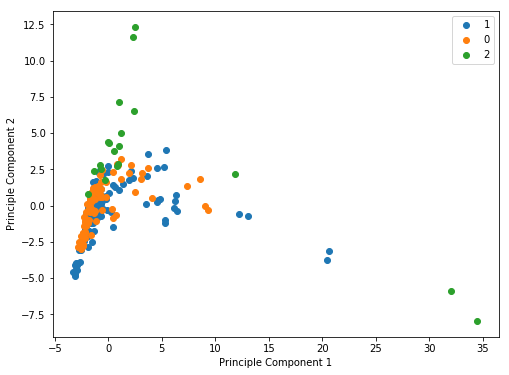

In [30]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

DataClusters, km = TrainTestCluster(tasks, 3)

In [27]:
DataClusters.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,Cluster,RMSX,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drwg,0,1.0,0.0,0.0,1.0,5,0.000775,...,1.799307,1.841770,2.007121,0.000030,0.002051,0.000316,0.000290,1.869467,5.981329,0.027008
1,1003.0,0,Drwg,1,1.0,0.0,0.0,1.0,1,0.000574,...,1.632427,1.743253,2.242265,0.000023,0.001307,0.000267,0.000244,1.544128,2.446828,0.018654
2,1003.0,0,Drwg,2,1.0,0.0,0.0,1.0,5,0.000426,...,1.822360,1.922256,2.100948,0.000026,0.002432,0.000294,0.000293,2.890688,13.503555,0.018269
3,1003.0,0,Drwg,3,1.0,0.0,0.0,1.0,4,0.000407,...,1.880639,1.997763,2.133789,0.000026,0.002425,0.000294,0.000283,2.977380,15.189153,0.020318
4,1003.0,0,Drwg,4,1.0,0.0,0.0,1.0,4,0.000393,...,2.045540,1.708935,2.093872,0.000022,0.001229,0.000267,0.000216,1.405528,2.365242,0.024141


In [31]:
for cluster in DataClusters.Cluster.unique():
    ClusterData = DataClusters[DataClusters.Cluster == cluster]
    print('------------------------------')
    print('Cluster ' + str(cluster))
    print(len(ClusterData))
    print('Mean Trem: ' + str(ClusterData.Tremor.mean()))
    print('Mean Brad: ' + str(ClusterData.Bradykinesia.mean()))
    print('Mean Dys: ' + str(ClusterData.Dyskinesia.mean()))
    print('------------------------------')

------------------------------
Cluster 1
1869
Mean Trem: 0.3156768325307651
Mean Brad: 0.2257495590828924
Mean Dys: 0.07276618512573568
------------------------------
------------------------------
Cluster 2
1015
Mean Trem: 0.29261083743842364
Mean Brad: 0.34564643799472294
Mean Dys: 0.09655172413793103
------------------------------
------------------------------
Cluster 0
1673
Mean Trem: 0.29228930065750147
Mean Brad: 0.21505376344086022
Mean Dys: 0.11177525403466826
------------------------------
